In [1]:
%pylab inline 

%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'..')

from tensorflow_probability.python.internal.backend import jax as tf
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax

Populating the interactive namespace from numpy and matplotlib


In [2]:
from jax_nf.real_nvp import RealNVP

In [52]:
from flax import nn
import jax
import jax.numpy as np
import numpy as onp
import flax

tfd = tfp.distributions
tfb = tfp.bijectors

In [135]:
@nn.module
def AffineCoupling(x, nunits, apply_scaling=True):

  # Let's have one more non stupid lyerre
  net = nn.leaky_relu(nn.Dense(x, 128))
  net = nn.leaky_relu(nn.Dense(net, 128))
    
  shift = nn.Dense(net, nunits)
  if apply_scaling:
    scaler = tfb.Scale(np.clip(np.exp(nn.Dense(net, nunits)), 1e-3, 1e3))
  else:
    scaler = tfb.Identity()
  return  tfb.Chain([ tfb.Shift(shift), scaler])

In [136]:
# Instantiate the splines
d = 2
dummy_input = np.zeros((1, d//2))
_, params1 = AffineCoupling.init(jax.random.PRNGKey(0), dummy_input, d//2)

In [137]:
from functools import partial
affine1 = partial(AffineCoupling.call, params1)

In [138]:
nvp = tfd.TransformedDistribution(
        tfd.Normal(0,1),
        bijector=RealNVP(1, bijector_fn=affine1),
        event_shape=(2,))

In [139]:
samps = nvp.sample((1000,), seed=jax.random.PRNGKey(1))

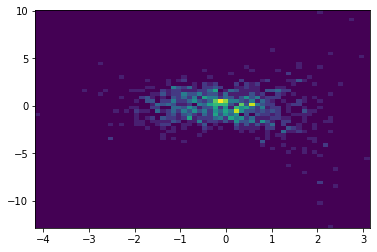

In [140]:
hist2d(samps[:,0], samps[:,1],64);

In [141]:
# Sweet :-D Hurray for TFP

In [142]:
# Let's try to learn a density

In [143]:
d=2
@nn.module
def AffineFlow(x):
    
    affine1 = AffineCoupling.shared(name='affine1')
    affine2 = AffineCoupling.shared(name='affine2')
    affine3 = AffineCoupling.shared(name='affine3',apply_scaling=False)
    affine4 = AffineCoupling.shared(name='affine4',apply_scaling=False)
    affine5 = AffineCoupling.shared(name='affine5',apply_scaling=False)
    affine6 = AffineCoupling.shared(name='affine6',apply_scaling=False)
    
    # Computes the likelihood of these x
    chain = tfb.Chain([
        RealNVP(d//2, bijector_fn=affine1),
        tfb.Permute([1,0]),
        RealNVP(d//2, bijector_fn=affine2),
        tfb.Permute([1,0]),
        RealNVP(d//2, bijector_fn=affine3),
        tfb.Permute([1,0]),
        RealNVP(d//2, bijector_fn=affine4),
        tfb.Permute([1,0]),
        RealNVP(d//2, bijector_fn=affine5),
        tfb.Permute([1,0]),
        RealNVP(d//2, bijector_fn=affine6)
    ])
    
    nvp = tfd.TransformedDistribution(
                tfd.Normal(0,1),
                bijector=chain,
                event_shape=(d,))
    
    return nvp.log_prob(x)

In [144]:
dummy_input = np.zeros((1,d))
res, params = AffineFlow.init(jax.random.PRNGKey(0), dummy_input)

In [145]:
model = nn.Model(AffineFlow, params)

In [146]:
# Ok, sweet
@jax.jit
def train_step(optimizer, batch):
    
    def loss_fn(model):
        log_prob = model(batch['x'])
        return -np.mean(log_prob)
    
    loss, grad = jax.value_and_grad(loss_fn)(optimizer.target)
    optimizer = optimizer.apply_gradient(grad)
    return loss, optimizer

In [147]:
# Now let's draw ou famous two moons
from sklearn import datasets

batch_size=1024
def get_batch():
    x, y = datasets.make_moons(n_samples=batch_size, noise=.05)
    return {'x': x}

In [148]:
# okokokok, let's try it out
optimizer = flax.optim.Adam(learning_rate=0.001).create(model)
losses = []

In [155]:
for i in range(2000):
    batch = get_batch()
    l, optimizer = train_step(optimizer, batch)
    losses.append(l)
    if  i %100 ==0:
        print(l)

0.5350232
0.506029
0.4795205
0.5871968
0.57308793
0.47504598
0.43112496
0.4330474
0.40758747
0.4637806
0.77724886
0.5377247
0.47697845
0.5463549
0.4833246
0.4976281
0.48014975
0.50423646
0.49604598
0.39657426


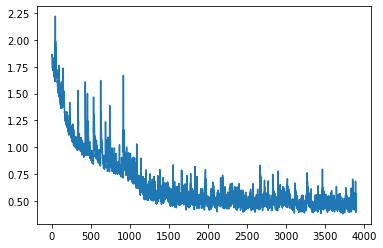

In [156]:
plot(losses[100:])

In [157]:
# ok, fine, let's see if we can rebuild our flow
@nn.module
def AffineFlowSampler(key, n_samples):
    
    affine1 = AffineCoupling.shared(name='affine1')
    affine2 = AffineCoupling.shared(name='affine2')
    affine3 = AffineCoupling.shared(name='affine3',apply_scaling=False)
    affine4 = AffineCoupling.shared(name='affine4',apply_scaling=False)
    affine5 = AffineCoupling.shared(name='affine5',apply_scaling=False)
    affine6 = AffineCoupling.shared(name='affine6',apply_scaling=False)
    
    # Computes the likelihood of these x
    chain = tfb.Chain([
        RealNVP(d//2, bijector_fn=affine1),
        tfb.Permute([1,0]),
        RealNVP(d//2, bijector_fn=affine2),
        tfb.Permute([1,0]),
        RealNVP(d//2, bijector_fn=affine3),
        tfb.Permute([1,0]),
        RealNVP(d//2, bijector_fn=affine4),
        tfb.Permute([1,0]),
        RealNVP(d//2, bijector_fn=affine5),
        tfb.Permute([1,0]),
        RealNVP(d//2, bijector_fn=affine6)
    ])
    
    nvp = tfd.TransformedDistribution(
                tfd.Normal(0,1),
                bijector=chain,
                event_shape=(d,))
    
    return nvp.sample(n_samples, seed=key)

In [158]:
sampler = nn.Model(AffineFlowSampler, optimizer.target.params)

In [159]:
samps = sampler(jax.random.PRNGKey(1),1000)

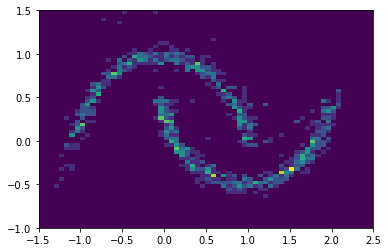

In [161]:
hist2d(samps[:,0], samps[:,1],64, [[-1.5,2.5],[-1.,1.5]]);
